# Leaky-integrate-and-fire model

**Book chapters**

See [Chapter 1 Section 3](http://neuronaldynamics.epfl.ch/online/Ch1.S3.html) on general information about
leaky-integrate-and-fire models.

**Python classes**

The `leaky_integrate_and_fire.LIF` implements a parameterizable LIF model. Call `LIF.getting_started()` and have a look at it’s source code to learn how to efficiently use the `leaky_integrate_and_fire.LIF` module.

A typical Jupyter notebook looks like this:

nr of spikes: 0


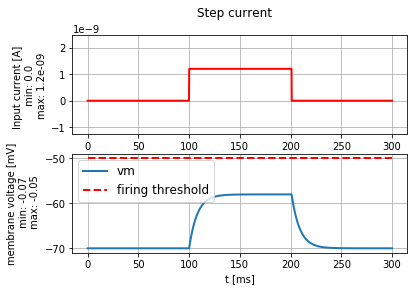

nr of spikes: 5


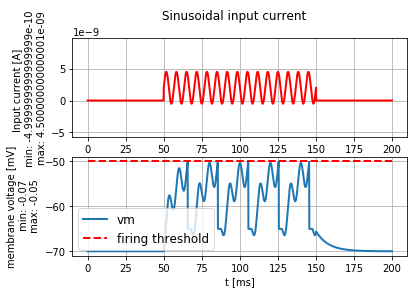

Resting potential: -0.07
Reset voltage: -0.065
Firing threshold: -0.05
Membrane resistance: 10000000.0
Membrane time-scale: 0.008
Absolute refractory period: 0.002


In [2]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex.leaky_integrate_and_fire import LIF
from neurodynex.tools import input_factory, plot_tools


LIF.getting_started()
LIF.print_default_parameters()


![exercises/exc_images/LIF_getting_started.png](exercises/exc_images/LIF_getting_started.png)Injection of a sinusoidal current into a leaky-integrate-and-fire neuron  
Note that you can change all parameter of the LIF neuron by using the named parameters of the function `simulate_LIF_neuron()`. If you do not specify any parameter, the following default values are used:

In [2]:
V_REST = -70*b2.mV
V_RESET = -65*b2.mV
FIRING_THRESHOLD = -50*b2.mV
MEMBRANE_RESISTANCE = 10. * b2.Mohm
MEMBRANE_TIME_SCALE = 8. * b2.ms
ABSOLUTE_REFRACTORY_PERIOD = 2.0 * b2.ms

## Exercise: minimal current

In the absence of an input current, a LIF neuron has a constant membrane voltage vm=v_rest. If an input current drives vm above the firing threshold, a spike is generated. Then, vm is reset to v_reset and the neuron ignores any input during the refractroy period.

### Question: minimal current (calculation)

For the default neuron parameters (see above) compute the minimal amplitude **i_min** of a step current to elicitate a spike. You can access these default values in your code and do the calculation with correct units:

In [77]:

from neurodynex.leaky_integrate_and_fire import LIF
print("resting potential: {}".format(LIF.V_REST))


resting potential: -0.07


### Answer
Since $u(t) = u_{rest} + \frac{R}{\tau}\int_0^\infty e^{-s/\tau} I(t-s)\:ds$ and we are providing a step input $I(t) = I_{min}\Theta(t)\Theta(100\text{ ms}-t)$

$$u(t) = u_{rest} + \frac{RI_{min}}{\tau} \int^0_{100\text{ ms}} e^{-s/\tau}\:ds = u_{rest} +I_{min} \big[R e^{-t/\tau}\big]^0_{100\text{ ms}}$$

We want $u(t)$ to reach the threshold $\vartheta$, so our current $I_{min}$ must be:

$$I_{min} = \frac{\vartheta - u_{rest}}{\big[R e^{t/\tau}\big]^0_{100\text{ ms}}}$$

In [29]:
import numpy as np
u_rest = LIF.V_REST
R = LIF.MEMBRANE_RESISTANCE
τ = LIF.MEMBRANE_TIME_SCALE
θ = LIF.FIRING_THRESHOLD
I_min = (θ-u_rest)/(R*(1-np.exp(-100*b2.ms/τ)))
I_min


2.00000745 * namp

### Question: minimal current (simulation)

Use the value **i_min** you’ve computed and verify your result: inject a step current of amplitude i_min for 100ms into the LIF neuron and plot the membrane voltage. Vm should approach the firing threshold but *not* fire. We have implemented a couple of helper functions to solve this task. Use this code block, but make sure you understand it and you’ve read the docs of the functions `LIF.simulate_LIF_neuron()`, `input_factory.get_step_current()` and `plot_tools.plot_voltage_and_current_traces()`.

nr of spikes: 0
nr of spikes: 0
nr of spikes: 1


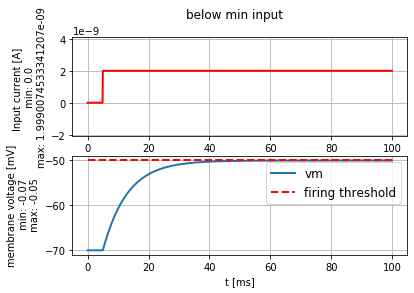

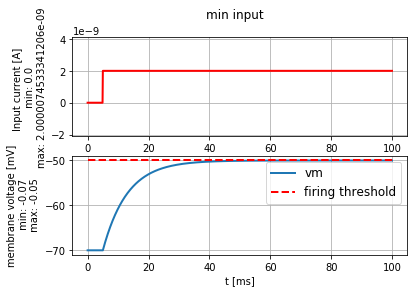

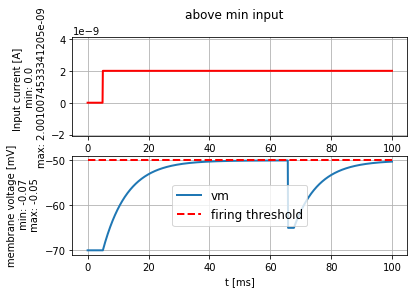

<Figure size 432x288 with 0 Axes>

In [76]:
import brian2 as b2
from neurodynex.leaky_integrate_and_fire import LIF
from neurodynex.tools import input_factory

for deviation, title in zip([-0.001, 0.0, +0.001], ['below min input', 'min input', 'above min input']):

    # create a step current with amplitude= i_min
    step_current = input_factory.get_step_current(
        t_start=5, t_end=100, unit_time=b2.ms,
        amplitude=I_min+deviation*b2.namp)  # set i_min to your value

    # run the LIF model.
    # Note: As we do not specify any model parameters, the simulation runs with the default values
    (state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = 100 * b2.ms)

    # plot I and vm
    plot_tools.plot_voltage_and_current_traces(
    state_monitor, step_current, title=title, firing_threshold=LIF.FIRING_THRESHOLD)
    print("nr of spikes: {}".format(spike_monitor.count[0]))  # should be 0
    plt.figure() # Create a new figure for the next plot


## Exercise: f-I Curve

For a constant input current I, a LIF neuron fires regularly with firing frequency f. If the current is to small (I < I_min) f is 0Hz; for larger I the rate increases. A neuron’s firing-rate versus input-amplitude relationship is visualized in an “f-I curve”.

### Question: f-I Curve and refractoryness

We now study the f-I curve for a neuron with a refractory period of 3ms (see `LIF.simulate_LIF_neuron()` to learn how to set a refractory period).

1. Sketch the f-I curve you expect to see  
1. What is the maximum rate at which this neuron can fire?  
1. Inject currents of different amplitudes (from 0nA to 100nA) into a LIF neuron. For each current, run the simulation for 500ms and determine the firing frequency in Hz. Then plot the f-I curve. Pay attention to the low input current.  

### Answer
1. The higher the current $I$, the higher the firing frequency $f$. Also if the neuron has a current threshold $I_{min}$, the frequency will be 0 until this threshold is reached:

<img src="Sketch_f-I.jpg" width=300 />
this growth can be either slower with increasing $I$, constant, or faster with increasing $I$ (possible options from top to bottom).

In [193]:
freq = []
I = np.linspace(-1, np.log(100), 40)
I = np.exp(I) # After experimenting with I values, exponential space seems the best choice
for factor in I:

    t_end = 1000

    step_current = input_factory.get_step_current(
        t_start=5, t_end=t_end, unit_time=b2.ms,
        amplitude=factor*I_min)

    # run the LIF model.
    # Note: As we do not specify any model parameters, the simulation runs with the default values
    (state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = t_end * b2.ms, 
                                    abs_refractory_period=3*b2.ms)

    freq.append(spike_monitor.count[0]/(t_end * b2.ms))

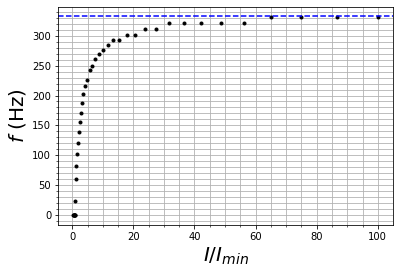

In [205]:
plt.plot(I, freq, '.k')
plt.axhline(1000/3, c='b', linestyle="--") # Maximum rate is 1000/3 Hz = 333.33 Hz
plt.xlabel('$I/I_{min}$', fontdict={'size':20})
plt.ylabel('$f$ (Hz)', fontdict={'size':20})
plt.minorticks_on()
plt.grid(True, which='both')
# There are some I which have the same f because we are only counting spikes in a finite time interval
# In this interval, this nearby frequencies f differ in less than one spike

## My Experiments

frequency:


3. * hertz

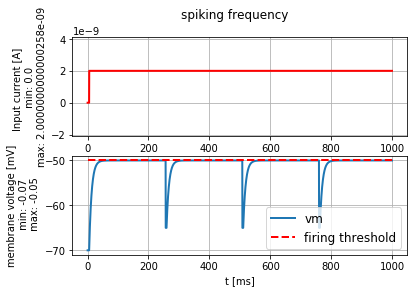

In [310]:
t_end = 1000

step_current = input_factory.get_step_current(
    t_start=5, t_end=t_end, unit_time=b2.ms,
    amplitude=0.9999962733468405*I_min) # Exact value of I_min (?)

# run the LIF model.
# Note: As we do not specify any model parameters, the simulation runs with the default values
(state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = t_end * b2.ms, 
                                abs_refractory_period=3*b2.ms)

# plot I and vm
plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="spiking frequency", firing_threshold=LIF.FIRING_THRESHOLD)
print("frequency:")
spike_monitor.count[0]/(t_end * b2.ms)

frequency:


10. * hertz

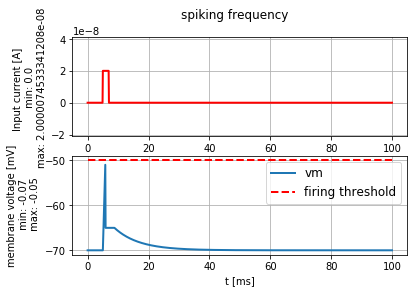

In [312]:
t_end = 100

step_current = input_factory.get_step_current(
    t_start=5, t_end=6, unit_time=b2.ms,
    amplitude=10*I_min) # Delta function impulse

# run the LIF model.
# Note: As we do not specify any model parameters, the simulation runs with the default values
(state_monitor,spike_monitor) = LIF.simulate_LIF_neuron(input_current=step_current, simulation_time = t_end * b2.ms, 
                                abs_refractory_period=3*b2.ms)

# plot I and vm
plot_tools.plot_voltage_and_current_traces(
state_monitor, step_current, title="spiking frequency", firing_threshold=LIF.FIRING_THRESHOLD)
print("frequency:")
spike_monitor.count[0]/(t_end * b2.ms)

## Exercise: “Experimentally” estimate the parameters of a LIF neuron

A LIF neuron is determined by the following parameters: Resting potential, Reset voltage, Firing threshold, Membrane resistance, Membrane time-scale, Absolute refractory period. By injecting a known test current into a LIF neuron (with unknown parameters), you can determine the neuron properties from the voltage response.

### Question: “Read” the LIF parameters out of the vm plot

1. Get a random parameter set  
1. Create an input current of your choice.  
1. Simulate the LIF neuron using the random parameters and your test-current. Note that the simulation runs for a fixed duration of 50ms.  
1. Plot the membrane voltage and estimate the parameters. You do not have to write code to analyse the voltage data in the StateMonitor. Simply estimate the values from the plot. For the Membrane resistance and the Membrane time-scale you might have to change your current.  
1. compare your estimates with the true values.  


Again, you do not have to write much code. Use the helper functions:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f595f689c90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f596025da90>)

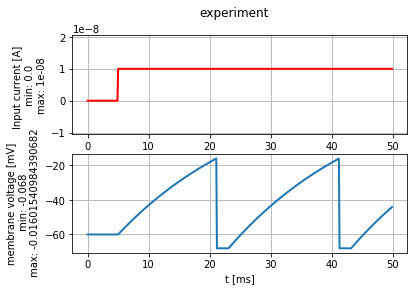

In [12]:

# get a random parameter. provide a random seed to have a reproducible experiment
random_parameters = LIF.get_random_param_set(random_seed=432)

# define your test current
test_current = input_factory.get_step_current(
    t_start=5, t_end=50, unit_time=b2.ms, amplitude= 10.0* b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")

# print the parameters to the console and compare with your estimates
# LIF.print_obfuscated_parameters(random_parameters)


$\vartheta \sim -18\text{ mV}$

$V_{rest} = -60 \text{ mV}$

$V_{reset} \sim -65\text{ mV}$

(<matplotlib.axes._subplots.AxesSubplot at 0x7f595a4be410>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f595ee96850>)

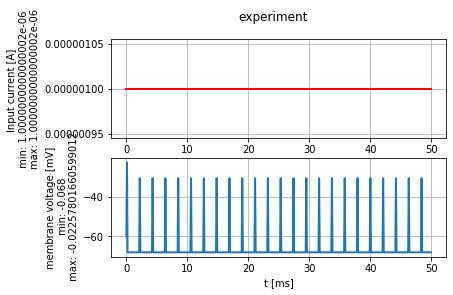

In [45]:

# get a random parameter. provide a random seed to have a reproducible experiment
random_parameters = LIF.get_random_param_set(random_seed=432)

# define your test current
test_current = input_factory.get_step_current(
    t_start=0, t_end=50, unit_time=b2.ms, amplitude= 1000.0* b2.namp)

# probe the neuron. pass the test current AND the random params to the function
state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

# plot
plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")

# print the parameters to the console and compare with your estimates
# LIF.print_obfuscated_parameters(random_parameters)


Refractory period $\sim 2\text{ ms}$

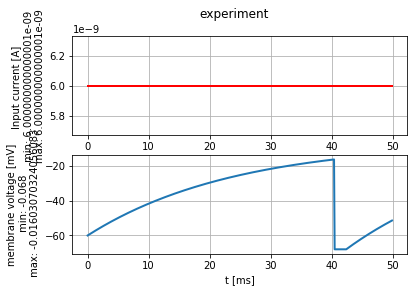

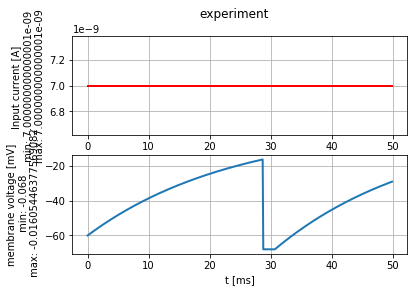

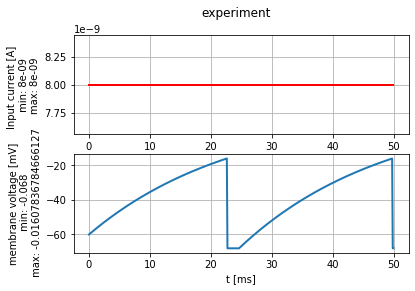

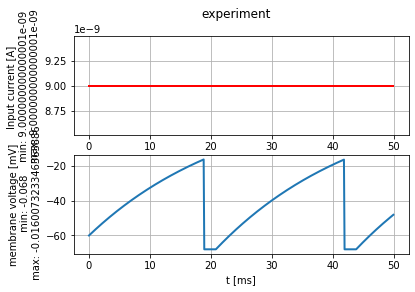

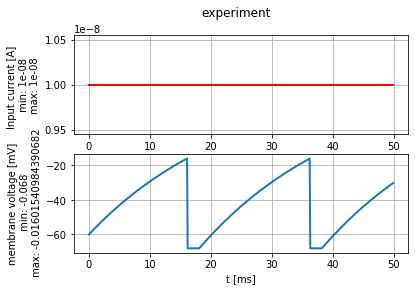

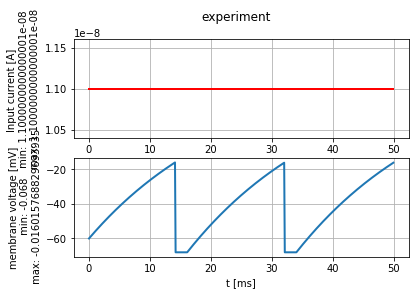

<Figure size 432x288 with 0 Axes>

In [47]:
for I in np.arange(6, 12):
    # get a random parameter. provide a random seed to have a reproducible experiment
    random_parameters = LIF.get_random_param_set(random_seed=432)

    # define your test current
    test_current = input_factory.get_step_current(
        t_start=0, t_end=50, unit_time=b2.ms, amplitude= I* b2.namp)

    # probe the neuron. pass the test current AND the random params to the function
    state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

    # plot
    plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")
    plt.figure() # Create a new figure for the next plot

    # print the parameters to the console and compare with your estimates
    # LIF.print_obfuscated_parameters(random_parameters)


| $I_0\text{ (mA)}$ | $t_0\text{ (ms)}$ |
| ----------------- |:-----------------:|
|       $6$         |        $40$       |
|       $7$         |        $28$       |
|       $8$         |        $22$       |
|       $9$         |        $19$       |
|       $10$        |        $16$       |
|       $11$        |        $14$       |


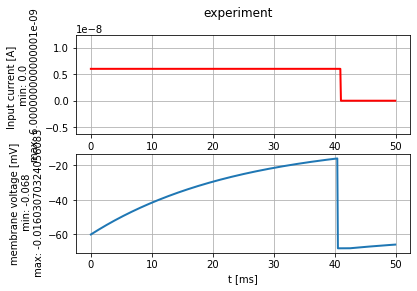

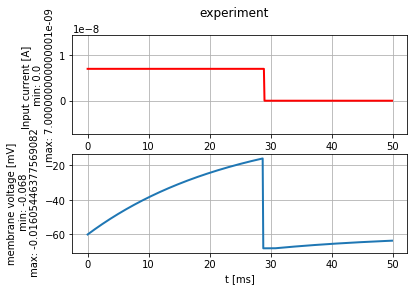

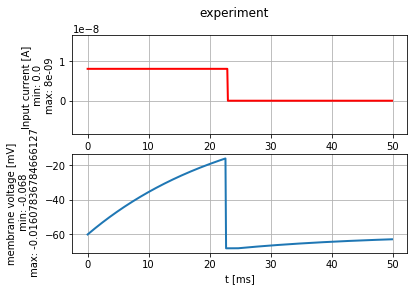

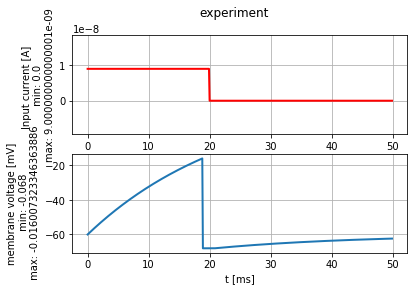

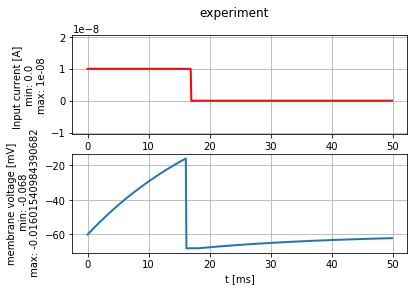

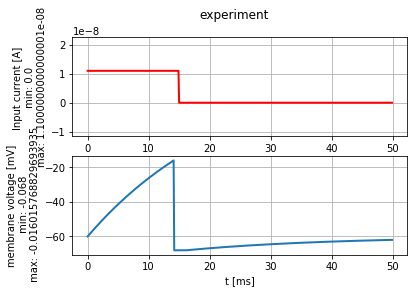

<Figure size 432x288 with 0 Axes>

In [48]:
for I, time in zip(np.arange(6, 12), [40, 28, 22, 19, 16, 14]):
    # get a random parameter. provide a random seed to have a reproducible experiment
    random_parameters = LIF.get_random_param_set(random_seed=432)

    # define your test current
    test_current = input_factory.get_step_current(
        t_start=0, t_end=time, unit_time=b2.ms, amplitude= I* b2.namp)

    # probe the neuron. pass the test current AND the random params to the function
    state_monitor, spike_monitor = LIF.simulate_random_neuron(test_current, random_parameters)

    # plot
    plot_tools.plot_voltage_and_current_traces(state_monitor, test_current, title="experiment")
    plt.figure() # Create a new figure for the next plot

    # print the parameters to the console and compare with your estimates
    # LIF.print_obfuscated_parameters(random_parameters)

$2\tau \sim 50-14;\;\tau \sim 18\text{ ms}$

$u(t) = u_{rest} + RI_0 (1-e^{-t_0/\tau}) = \vartheta$

But since we don't know $R$ nor $\tau$, we need an alternative way to calculate one of them (or fit the data using some form of regression, but it's too complicated for our purpose)

| $I_0\text{ (mA)}$ | $t_0\text{ (ms)}$ |
| ----------------- |:-----------------:|
|       $6$         |        $40$       |
|       $7$         |        $28$       |
|       $8$         |        $22$       |
|       $9$         |        $19$       |
|       $10$        |        $16$       |
|       $11$        |        $14$       |

With this table what we _can_ do is stop the pulse at $t_0$, so that we can measure the time it takes the voltage to get from $V_{rest}$ to $V_{reset}$


In [56]:
I_0 = np.arange(6, 12) * b2.namp
t0 = np.array([40, 28, 22, 19, 16, 14]) * b2.ms
τ = 18 * b2.ms
θ = -18 * b2.mvolt
u_rest = -60 * b2.mvolt
R = (u_rest - θ)/(I_0*(np.exp(-t0/τ)-1))
R.mean()

7.3751818 * Mohm

Resting potential: $V_{rest} = -60 \text{ mV}$

Reset voltage: $V_{reset} \sim -65\text{ mV}$

Firing threshold: $\vartheta \sim -18\text{ mV}$

Membrane resistance: $R \sim 7.4 \text{ M}\Omega$

Membrane time-scale: $\tau \sim 18\text{ ms}$

Absolute refractory period: $\tau_{ref} \sim 2\text{ ms}$

In [64]:
LIF.print_obfuscated_parameters(random_parameters)

Resting potential: -0.06
Reset voltage: -0.068
Firing threshold: -0.016
Membrane resistance: 9000000.0
Membrane time-scale: 0.024
Absolute refractory period: 0.002


## Exercise: Sinusoidal input current and subthreshold response

In the subthreshold regime (no spike), the LIF neuron is a linear system and the membrane voltage is a filtered version of the input current. In this exercise we study the properties of this linear system when it gets a sinusoidal stimulus.

### Question

Create a sinusoidal input current (see example below) and inject it into the LIF neuron. Determine the phase and amplitude of the membrane voltage.

nr of spikes: 0


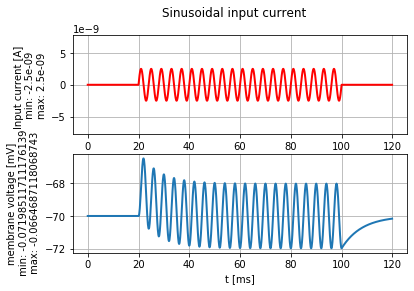

In [65]:
# note the higher resolution when discretizing the sine wave: we specify unit_time=0.1 * b2.ms
sinusoidal_current = input_factory.get_sinusoidal_current(200, 1000, unit_time=0.1 * b2.ms,
                                            amplitude= 2.5 * b2.namp, frequency=250*b2.Hz,
                                            direct_current=0. * b2.namp)

# run the LIF model. By setting the firing threshold to to a high value, we make sure to stay in the linear (non spiking) regime.
(state_monitor, spike_monitor) = LIF.simulate_LIF_neuron(input_current=sinusoidal_current, simulation_time = 120 * b2.ms, firing_threshold=0*b2.mV)

# plot the membrane voltage
plot_tools.plot_voltage_and_current_traces(state_monitor, sinusoidal_current, title="Sinusoidal input current")
print("nr of spikes: {}".format(spike_monitor.count[0]))


### Question

For input frequencies between $ 10 Hz $ and $ 1 kHz $, plot the   the resulting *amplitude of subthreshold oscillations* of the membrane potential vs. input frequency.

### Question

For input frequencies between $ 10 Hz $ and $ 1 kHz $, plot the resulting *phase shift of subthreshold oscillations* of the membrane potential vs. input frequency.

### Question

To what type of filter (High-Pass, Low-Pass) does this correspond?

>**Note**
>
>It is not straight forward to automatically determine the phase shift in a script. For this exercise, simply get it “visually” from your plot. If you want to automatize the procedure in your Python script you could try the function scipy.signal.correlate().

## Book questions
1. **Synaptic current pulse**. _Synaptic inputs can be approximated by an exponential current $I(t) = q\frac{1}{\tau_s} \exp \left[ -\frac{t-t^f}{\tau_s} \right]$ for $t > t^f$ where $t^f$ is the moment when the spike arrives at the synapse._

_(a) Use Eq. (1.5) to calculate the response of a passive membrane with time constant $\tau_m$ to an input spike arriving at time $t^f$_

_(b) In the solution resulting from (a), take the limit $\tau_s \to \tau_m$ and show that in this limit the
f
response is proportional to $[t - t^f]\exp\left[ -\frac{t-t^f}{\tau_s} \right]$. A function of this form is sometimes called an α-function._

_(c) In the solution resulting from (a), take the limit $\tau_s \to 0$. Can you relate your result to the
discussion of the Dirac- δ function?_
